In [88]:
import numpy as np
#Initialize paramters
n = 100
delta = 0.05
k = np.ceil(np.log2(   np.sqrt(  n   /  np.log(1/delta))  / 2 ))
lambda_grid= (np.ones(int(k))*1/2)**(np.arange(start = 1, stop = int(k+1)))
Z_values = np.array([0, 1/2, 1])
p_grid = np.arange(0,1.01,0.01)

In [89]:
#Define utility functions

#Function for sampling n from a distribution P(Z)
def draw_n(Z, p, n):
    probs = (1-p)/2 # Compute probabilities for non-central value
    distribution = np.array([probs, p, probs]) # compute probability vector for Z
    sample = np.random.choice(Z, size = n, p = distribution) # sample from distribution
    return sample


def kl(p,q): #define kl-function
    if p == 1 or p == 0: #handle exceptions
        return 0
    return(p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))) # Define kl-function 

# Function for finding the (upper) inverse of the kl-function
# Input phat and z, where the inverse kl-function given phat is calculated at z

def klinverse_upper(phat, z):
    low = phat # Initialise lowest and highest possible solutions
    high = 1
    while(high - low > 0.0000001): # Set tolerance to 0.0000001
        mid = (high + low)/2 # Find midpoint
        if(kl(phat, mid) <= z): # experiment if kl() evaluated on the average is less than given z
            low = mid #If lower, raise the low value to the mid value
        else:
            high = mid # Else lower the high value to the mid value
    return(low) # Return the low value, for the maximal p where inequality still holds

In [90]:
# Define a sampling class for p_hat and v_hat and corresponding bounds with different values of p to try, the values that Z can take, n and delta
class Sample:
    def __init__(self, p_grid, Z_values, n, delta):
        self.p_grid = p_grid
        self.Z_values = Z_values
        self.n = n
        self.delta = delta
        self.k = np.ceil(np.log2(   np.sqrt(  self.n   /  np.log(1/self.delta))  / 2 )) # Calculate k
        self.lambda_grid = (np.ones(int(self.k))*1/2)**(np.arange(start = 1, stop = int(self.k+1))) # Calculate lambda grid
    
    #Method to generate array of p-hats and v-hats
    def generate_samples(self):
        # Initialize empty arrays
        self.p_hat = np.empty(0)
        self.v_hat = np.empty(0)
        
        #Loop over p's in grid
        for p in self.p_grid:
            n_Z = draw_n(Z = self.Z_values, p=p , n= self.n) # draw samples
            p_hat = np.mean(n_Z) # p_hat
            self.p_hat = np.append(self.p_hat, p_hat) # append to array
            v_hat = np.mean(n_Z**2) # v_hat
            self.v_hat =np.append(self.v_hat, v_hat) # append to array

    #Method for calculation of Bernstein bound
    def bernstein(self):
        self.bernstein_bound = np.min(np.array([lambda_*self.v_hat + (np.log(self.k/self.delta))/(lambda_*self.n) for lambda_ in self.lambda_grid]), axis=0)
    
    #Method for calculation of the kl bound
    def kl_calc(self):
        self.kl_bound = np.empty(0)
        for p_hat in self.p_hat:
            bound = klinverse_upper(phat = p_hat, z = np.log(  (self.n+1)  /self.delta)/(self.n)) - p_hat
            self.kl_bound = np.append(self.kl_bound, bound)
    
    #Method for aggregating n samples
    def aggregate_n(self,n):
        bern_bound = np.empty(0) # init arrays
        kl_bound = np.empty(0)
        for i in range(n): # repeat n times
            self.generate_samples() # generate samples
            self.bernstein() # calculate bounds
            self.kl_calc()
            bern_bound = np.append(bern_bound, self.bernstein_bound) # append to vectors
            kl_bound = np.append(kl_bound, self.kl_bound)
        bern_bound = np.reshape(bern_bound, (n, len(self.p_grid))) # reshape such that rows correspond to 1 sample
        kl_bound = np.reshape(kl_bound, (n,len(self.p_grid)))
        self.bern_smooth = np.mean(bern_bound, axis = 0) # take mean over columns
        self.kl_smooth = np.mean(kl_bound, axis = 0) # take mean over columns

In [92]:
experiment = Sample(p_grid=np.arange(0,1.01,0.01), Z_values=Z_values, n= 100, delta=delta)
experiment.generate_samples()
experiment.bernstein()
experiment.kl_calc()
experiment.aggregate_n(n=1000)

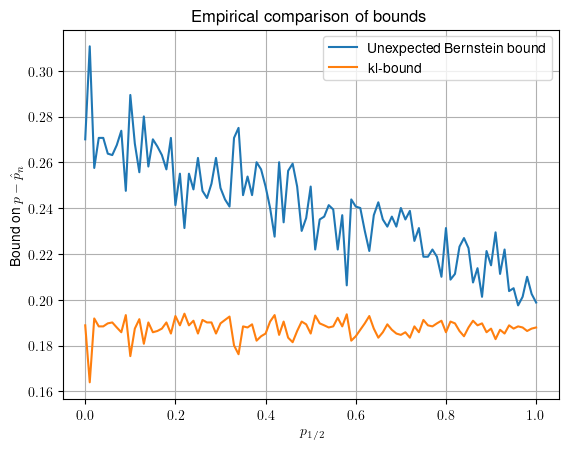

In [93]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
plt.plot(experiment.p_grid, experiment.bernstein_bound, label = "Unexpected Bernstein bound")
plt.plot(experiment.p_grid, experiment.kl_bound, label = "kl-bound")
plt.xlabel("$p_{1/2}$")
plt.ylabel("Bound on $p-\hat{p}_n$")
plt.title("Empirical comparison of bounds")
plt.grid()
plt.legend()
plt.savefig("emp.png")

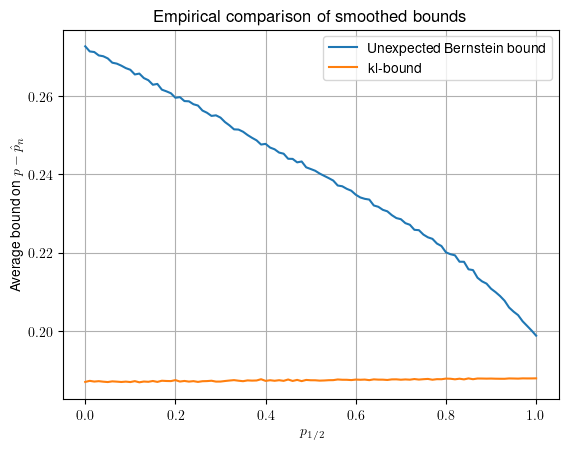

In [94]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
plt.plot(experiment.p_grid, experiment.bern_smooth, label = "Unexpected Bernstein bound")
plt.plot(experiment.p_grid, experiment.kl_smooth,  label ="kl-bound")
plt.xlabel("$p_{1/2}$")
plt.ylabel("Average bound on $p-\hat{p}_n$")
plt.title("Empirical comparison of smoothed bounds")
plt.grid()
plt.legend()
plt.savefig("emp_smooth.png")